In [1]:
# Install libraries
!pip install pycocotools pandas tqdm

import os
import random
import json
import requests
import pandas as pd
from tqdm import tqdm
from PIL import Image
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from IPython.display import display


In [2]:
pip freeze > requirements.txt

In [3]:
# Download COCO Annotations (captions only)
!mkdir -p /content/coco
!wget -q http://images.cocodataset.org/annotations/annotations_trainval2017.zip -P /content/coco/
!unzip -q /content/coco/annotations_trainval2017.zip -d /content/coco/

In [4]:
from pycocotools.coco import COCO
# Load captions
caption_file = "/content/coco/annotations/captions_train2017.json"
coco = COCO(caption_file)

# Sample 10% image IDs
all_img_ids = coco.getImgIds()
random.shuffle(all_img_ids)
subset_img_ids = all_img_ids[:1000]
imgs_info = coco.loadImgs(subset_img_ids)

# Download subset images (~3.5 GB total)
import os
from tqdm import tqdm
os.makedirs("/content/coco/train_subset", exist_ok=True)
base_url = "http://images.cocodataset.org/train2017/"

for img in tqdm(imgs_info, desc="Downloading images"):
    file_name = img["file_name"]
    url = base_url + file_name
    save_path = os.path.join("/content/coco/train_subset", file_name)

    if not os.path.exists(save_path):
        try:
            img_data = requests.get(url, timeout=5).content
            with open(save_path, "wb") as f:
                f.write(img_data)
        except:
            print(f"Failed: {file_name}")


loading annotations into memory...
Done (t=1.53s)
creating index...
index created!


In [5]:
# Create (image, caption) DataFrame
records = []
for img in tqdm(imgs_info, desc="Parsing captions"):
    img_id = img["id"]
    file_name = img["file_name"]
    ann_ids = coco.getAnnIds(imgIds=img_id)
    captions = coco.loadAnns(ann_ids)

    for cap in captions:
        records.append({
            "image_path": f"/content/coco/train_subset/{file_name}",
            "caption": cap["caption"]
        })

df = pd.DataFrame(records)
df.to_csv("/content/coco/coco_10percent.csv", index=False)
print("Saved to /content/coco/coco_10percent.csv")


Parsing captions: 100%|██████████| 1000/1000 [00:00<00:00, 56659.88it/s]

Saved to /content/coco/coco_10percent.csv


Caption: A cat lays on the table next to a cat in a bowl. 


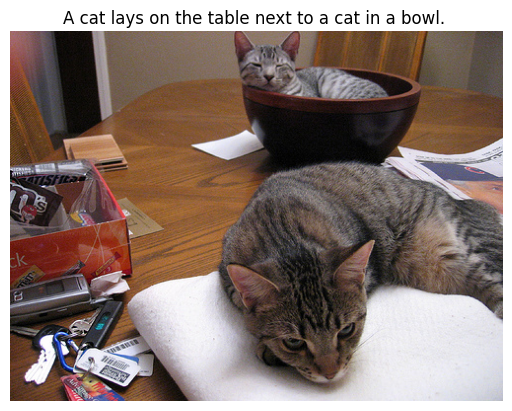

In [6]:
sample = df.sample(1).iloc[0]
print("Caption:", sample["caption"])
img = Image.open(sample["image_path"]).convert("RGB")
plt.imshow(img)
plt.axis('off')
plt.title(sample["caption"])
plt.show()


In [35]:
%%writefile app.py
import streamlit as st
import torch
from diffusers import StableDiffusionPipeline
from transformers import CLIPProcessor, CLIPModel
from PIL import Image

# Load Stable Diffusion model for image generation
@st.cache_resource
def load_sd_model():
    model = StableDiffusionPipeline.from_pretrained(
        "CompVis/stable-diffusion-v1-4",
        torch_dtype=torch.float16,
        revision="fp16"
    )
    return model.to("cuda")

# Load CLIP model to compute prompt-image relevance
@st.cache_resource
def load_clip_model():
    clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to("cuda").eval()
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    return clip_model, processor

# Compute raw CLIP similarity score (no softmax)
def get_clip_score(image, prompt, model, processor):
    inputs = processor(text=[prompt], images=image, return_tensors="pt", padding=True).to("cuda")
    with torch.no_grad():
        outputs = model(**inputs)
        score = outputs.logits_per_image[0][0].item()
    return round(score, 2)  # raw cosine similarity score

# Normalize score (optional) to percentage scale
def normalize_clip_score(score):
    # Empirical range: 15 to 30 → map to 0 to 100%
    return round(min(max((score - 15) * 5, 0), 100), 2)

# Load models
sd_model = load_sd_model()
clip_model, clip_processor = load_clip_model()

# Streamlit UI
st.title(" Text-to-Image Generator")
st.write("Type a prompt, generate an image, and see how well it matches!")

# Prompt input
prompt = st.text_input("Enter your prompt (e.g., 'A tiger in space')")

if st.button("Generate Image"):
    if not prompt:
        st.warning("Please enter a prompt.")
    else:
        with st.spinner("Generating image"):
            # Generate image
            image = sd_model(prompt).images[0]
            # Get CLIP similarity score
            raw_score = get_clip_score(image, prompt, clip_model, clip_processor)
            percent_score = normalize_clip_score(raw_score)

            # Display image and scores
            st.image(image, caption=prompt, use_container_width=True)
            st.markdown(f"** Relevance Score:** `{percent_score}%`")
            st.markdown(f"** Raw CLIP Score:** `{raw_score}`")



Overwriting app.py


In [36]:
! pip install streamlit -q

In [37]:
!wget -q -O - ipv4.icanhazip.com

35.204.215.151


In [ ]:
! streamlit run app.py & npx localtunnel --port 8501

⠙⠹⠸⠼⠴

⠦⠧⠇⠏⠋⠙
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.204.215.151:8501

⠹⠸⠼⠴⠦⠧your url is: https://five-zoos-work.loca.lt
2025-07-25 21:00:45.165774: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753477245.188711   27815 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753477245.195743   27815 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/diffusers/pipelines/pipeline_loading_utils.py:325: FutureWarning: You are loading the variant fp16 from CompVis/stable-diffusion-v1-4 via `revision='fp16'`. Th

In [10]:
|